In [29]:
import sim
%pylab inline
plt.style.use('seaborn-whitegrid')
pylab.rcParams['figure.figsize'] = (10.0, 6.0)

Populating the interactive namespace from numpy and matplotlib


### Check if python is connecting to Coppelia

In [30]:
sim.simxFinish(-1)  # Close opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    print('Simulation time in milliseconds: ', sim.simxGetLastCmdTime(clientID))
    
    # Get Object position
    name = 'Omnirob'
    err_code, cuboid = sim.simxGetObjectHandle(clientID, name, sim.simx_opmode_blocking)
    res, position = sim.simxGetObjectPosition(clientID, cuboid, -1, sim.simx_opmode_blocking)        
    print('Omnirob is at [x,y,z]=', position)
    
    # Now close the connection to CoppeliaSim:
    sim.simxGetPingTime(clientID)
    sim.simxFinish(clientID)
    print('Disconnected')
else:
    print('Failed connecting to remote API server')


Connected
Simulation time in milliseconds:  9300
Omnirob is at [x,y,z]= [7.624993324279785, 8.549184799194336, 0.35449859499931335]
Disconnected


# Robot

In [31]:
class robot():
    
    def __init__(self, frame_name, motor_names=[], client_id=0):  
        # If there is an existing connection
        if client_id:
                self.client_id = client_id
        else:
            self.client_id = self.open_connection()
            
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame =  self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object=-1):
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)        
        sim.simxSetObjectPosition(clientID, self.frame, relative_object, position, sim.simx_opmode_oneshot)
        
    def simtime(self):
        return sim.simxGetLastCmdTime(self.client_id)
    
    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)        
        return array(position)
    
    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):        
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

# Plot

In [246]:
def point_to_point_traj(x1, x2, v1, v2, delta_t):
  t = np.linspace(0, delta_t, 100) 
  ti = t[1]-t[0]
  a0 = x1
  a1 = v1
  a2 = (3*x2 - 3*x1 - 2*v1*delta_t - v2 * delta_t) / (delta_t**2)
  a3 = (2*x1 + (v1 + v2) * delta_t  - 2 * x2) / (delta_t**3)

  polynomial = a0 + a1 * t + a2 * t**2 + a3 * t**3
  derivative = a1 + 2*a2 * t + 3 * a3 * t**2
  return polynomial, derivative, ti


def piecewise2D (X,Y, Vx, Vy, T):
    theta_x, theta_y, dx, dy, time_steps = [], [], [], [], []

    for i in range(len(P)-1):          
        theta_xi, dxi, ti = point_to_point_traj(X[i], X[i+1], Vx[i], Vx[i+1], T[i+1] - T[i])
        theta_yi, dyi, ti = point_to_point_traj(Y[i], Y[i+1], Vy[i], Vy[i+1], T[i+1] - T[i])

        theta_x += theta_xi.tolist()
        theta_y += theta_yi.tolist()
        dx += dxi.tolist()
        dy += dyi.tolist()
        for j in range(100):
            time_steps.append(ti)
        

        plot(theta_xi, theta_yi)
    return theta_x, theta_y, dx, dy, time_steps

In [247]:
# Plotting
def plot_points():
    plot(X,Y, '--')
    plot(X,Y, 'o')
    quiver(X,Y, Vx, Vy, color='r')
    
# Speed
def plot_speed():
    speed = np.sqrt(np.array(dx)**2 + np.array(dy)**2)
    plot(speed)

In [372]:
##### Requirements for the trajectory

motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot

# Waypoints
p1 = r.get_position()
p2 = r.get_object_position('Sphere1')
p21 = [4.075,4.725,0]
p3 = r.get_object_position('Sphere')
p3[1] = p3[1]+0.4
p31 = [-3.7750,1.4,0]
p4 = r.get_object_position('Sphere0')
p5 = r.get_object_position('Sphere2')
p51 = [8.875,-4.075,0]
p6 = r.get_object_position('Sphere3')
p61 = [1.15,-7.225,0]
p62 = [-0.375,-1.8,0]
p63 = [-4.225,-8.5,0]
p7 = r.get_object_position('Sphere4')

# Velocities
v1 = [0.0001,0.]
v2 = [1,0]
v21 = [0,-1]
v3 = [-1,0]
v31 = [0,1]
v4 = [0,-1]
v5 = [1,0]
v51 = [0,-1]
v6 = [-1,0]
v61 = [0,1]
v62 = [-1,-1]
v63 = [-1,0]
v7 = [0.0001,0]


# Time
t1 = 0
t2 = t1 + 8
t21 = t2 + 8
t3 = t21 + 9
t31 = t3 + 10
t4 = t31 + 2
t5 = t4 + 25
t51 = t5 + 10
t6 = t51 + 10
t61 = t6 + 10
t62 = t61 + 7
t63 = t62 + 7
t7 = t63 + 10

Robot connected


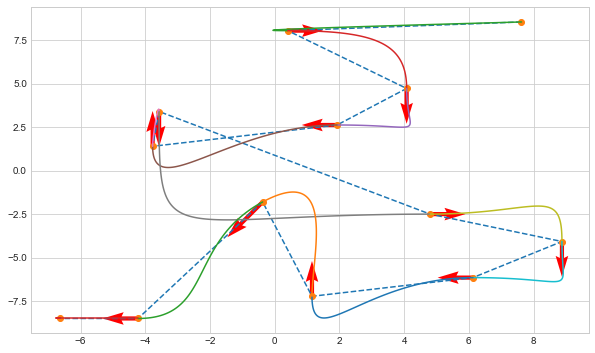

In [373]:
# Convert the initial conditions to a vector form
P = np.vstack((p1, p2, p21, p3, p31, p4, p5, p51, p6, p61, p62, p63, p7))
V = np.vstack((v1, v2, v21, v3, v31, v4, v5, v51, v6, v61, v62, v63, v7))
T = [t1, t2, t21, t3, t31, t4, t5, t51, t6, t61, t62, t63, t7]

X, Y = P[:,0], P[:,1]
Vx, Vy = V[:,0], V[:,1]

# gca().set_aspect("equal")
# ylim((-9,14))
# xlim((-7,12))

plot_points()

# Piecewise function
theta_x, theta_y, dx, dy, time_steps = piecewise2D(X,Y, Vx, Vy, T)

# Trajectory follower

In [375]:
r = robot(frame_name='Quadricopter_target')
r.set_position([0,1,0], 'Quadricopter_target')
r.close_connection()
# Joint name in coppelia
motor_names = ['Omnirob_FLwheel_motor', 'Omnirob_FRwheel_motor', 'Omnirob_RRwheel_motor', 'Omnirob_RLwheel_motor']
r = robot('Omnirob', motor_names)  # Create an instance of our robot

# Connect to the sphere that will be a reference
ref_point = robot('Sphere11', client_id=r.client_id)

# Initial locations
robot_position = r.get_position()
print('Robot position: (%.2f, %.2f) '%(robot_position[0], robot_position[1]))

for dxi, dyi, xi, yi, ti in zip(dx, dy, theta_x, theta_y, time_steps):
    traj_point = array([xi, yi])
    vel_traj = array([dxi, dyi])
    # ref_point.set_position(traj_point)
    robot_position = r.get_position()
    robot_position = array([robot_position[0], robot_position[1]])
    u = 10*(traj_point - robot_position) + vel_traj
    vx, vy = u
    r.send_motor_velocities([-vy - vx, vy - vx, vy + vx, -vy + vx])
    time.sleep(ti)

r.send_motor_velocities([0, 0, 0, 0])

r.close_connection()  # End

Robot connected
Connection closed
Robot connected
Robot connected
Robot position: (7.62, 8.55) 
Connection closed
